# The celebrated [DeiT Architecture](https://arxiv.org/pdf/2012.12877)
This is basically pure ViT. \
Only difference from $\emph{vanilla}$ ViT is adding a $\texttt{DIST}$ (distillation) token in addition to $\texttt{CLS}$, then teacher forcing that token's output with a strong teacher.

In [1]:
import warnings
warnings.filterwarnings("ignore")

from transformers import DeiTImageProcessor, DeiTModel
from torchvision import transforms
import torch
from PIL import Image
import requests

Some weights of DeiTModel were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


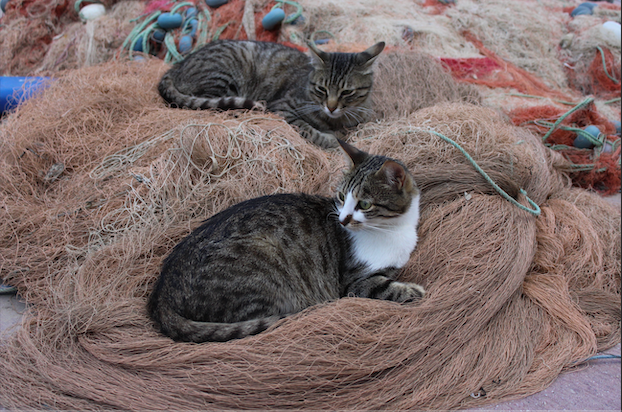

In [2]:
# Load model + processor
model_name = "facebook/deit-base-distilled-patch16-224"
model = DeiTModel.from_pretrained(model_name, use_safetensors=True)

# Example image
url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/cats.png"
image = Image.open(requests.get(url, stream=True).raw).convert("RGB")

image

In [3]:
# Normalization for DeiT (corresponds to ImageNet stats)
transform = transforms.Compose([
    transforms.ToTensor(),  # [0,1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

img_tensor = transform(image).unsqueeze(0)  # (1, 3, H, W)
print(f'{img_tensor.shape=}')  # e.g. [1, 3, 224, 224]
with torch.no_grad():
    outputs = model(pixel_values=img_tensor,  interpolate_pos_encoding=True, output_hidden_states=True)

# Skip CLS and DIST tokens - irrelevant for us since untrained and unused for us
patch_embeddings = outputs.last_hidden_state[:, 2:, :]

print("Patch embedding shape:", patch_embeddings.shape)  # e.g. [1, 196, 768] for 224x224

img_tensor.shape=torch.Size([1, 3, 412, 622])
Patch embedding shape: torch.Size([1, 950, 768])
